In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading cleaned reviews file
json_filename = 'reviews_cleaned.json'
reviews_df = pd.read_json(json_filename, orient='records', lines=True)

# Setting to display all columns
pd.set_option('display.max_columns', 999)

# Preparing TF-IDF transformer for review text
tfidf_transformer = TfidfVectorizer()

reviews_df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,This game is very realistic and is super fun! ...,1,1,0,0.000000,0,1,0,514,514,167,1703564483000,0.137000,6.244167,5.123964,6.244167,-0.613314,-0.834628,3.950013,0.324903,17,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.534623,0.667210
1,I've been having too much fun playing it. Keep...,1,1,0,0.000000,0,1,0,154,154,154,1703538758000,0.500000,5.043425,5.043425,5.043425,-1.279696,-0.884405,3.138292,1.000000,17,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.431025,0.593137
2,"A good, and I mean good, hacking simulator for...",1,3,0,0.543568,0,1,0,21,21,17,1703529507000,0.259430,3.091042,2.890372,3.091042,-2.363219,-2.215108,1.818448,0.809524,17,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.234024,0.452282
3,This is an amazingly realistic hacking simulat...,1,3,0,0.543568,0,1,0,46,46,35,1703529325000,0.405167,3.850148,3.583519,3.850148,-1.941935,-1.786706,2.331616,0.760870,17,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.338357,0.526880
4,As a security specialist of 20+ years you're d...,1,33,0,0.808946,0,1,0,410,410,181,1703563314000,0.650000,6.018593,5.204007,6.018593,-0.738502,-0.785157,3.797521,0.441463,17,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.540351,0.671305


In [2]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   review                              608 non-null    object 
 1   voted_up                            608 non-null    int64  
 2   votes_up                            608 non-null    int64  
 3   votes_funny                         608 non-null    int64  
 4   weighted_vote_score                 608 non-null    float64
 5   comment_count                       608 non-null    int64  
 6   steam_purchase                      608 non-null    int64  
 7   received_for_free                   608 non-null    int64  
 8   author_playtime_forever             608 non-null    int64  
 9   author_playtime_last_two_weeks      608 non-null    int64  
 10  author_playtime_at_review           608 non-null    int64  
 11  author_last_played                  608 non-n

In [3]:
# Choosing relevant features to avoid overfitting
categorical_features = ['playtime_category',  
                        'reviewer_experience']

numerical_features = [ # Playtime features
                      'normalized_playtime_forever', 
                      'normalized_playtime_last_two_weeks', 
                      'playtime_ratio', 
                      'days_from_last_played_time',
    
                       # Community Engagement features
                      'voted_up', 
                      'votes_up', 
                      'votes_funny',
                      'comment_count', 
                      'weighted_vote_score',
                      'engagement_score',
                      'textblob_sentiment', 
                      'vader_sentiment', 
                     
                       # Purchase behaviour features
                      'steam_purchase', 
                      'received_for_free', 
    
                       # Review features
                      'review_length', 
                      'review_word_count']

# Preparing transformer for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for categorical data and text data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),                                     # Handling OneHotEncoder for categorical features
        ('tfidf', tfidf_transformer, 'cleaned_reviews_NS')                                          # Applying TF-IDF vectorizer on text data
    ], remainder='passthrough')

# Defining the model
model = Pipeline(steps=[('preprocessor', preprocessor),                                             # Calling the preprocessed data
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])   # Setting RandomForestRegressor with 100 decision trees, random state for repeatibility

# Preparing target variable and features
X = reviews_df[numerical_features + categorical_features + ['cleaned_reviews_NS']]                  # Assigning all numerical, categorical and 'cleaned_review_NS' (No Stopword) as input features
y = reviews_df['retention_score_scaled']                                                            # Assigning retention score (scaled) as target label                       

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)           # Train 80%, Test 20%

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)                                                            # mean squared error for checking variance between actual and predicted scores
r2 = r2_score(y_test, y_pred)                                                                       # r-squared for checking how much the data fits well into the model

# Extracting feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Handling feature names from the preprocessor
cat_feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()   # for categorical feature names
tfidf_feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out() # for review vector names
feature_names = list(cat_feature_names) + list(tfidf_feature_names) + numerical_features

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0005318274881910794
R-squared: 0.96330110834642


A low MSE suggests high accuracy. A high R-squared suggests high effectiveness of model based on the input features.

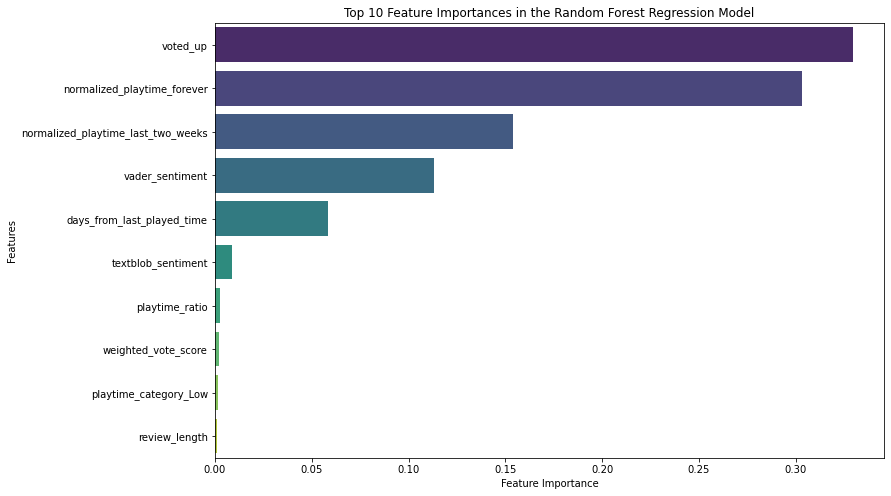

In [4]:
# Mapping feature importances to feature names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Selecting the top 10 features
top_10_features = dict(list(sorted_feature_importance.items())[:10]) # adjustable

# Plotting the top 10 features
plt.figure(figsize=(12, 8))
sns.barplot(x=list(top_10_features.values()), y=list(top_10_features.keys()), palette='viridis')
plt.title('Top 10 Feature Importances in the Random Forest Regression Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

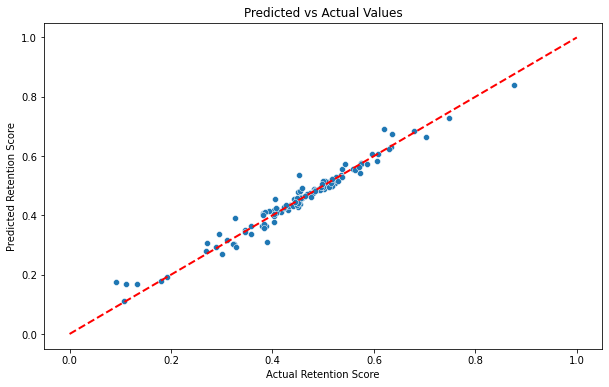

In [5]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Creating a dataFrame for visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicted vs Actual Values of Baseline Model')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Adding a diagonal line for reference (perfect prediction)
plt.show()

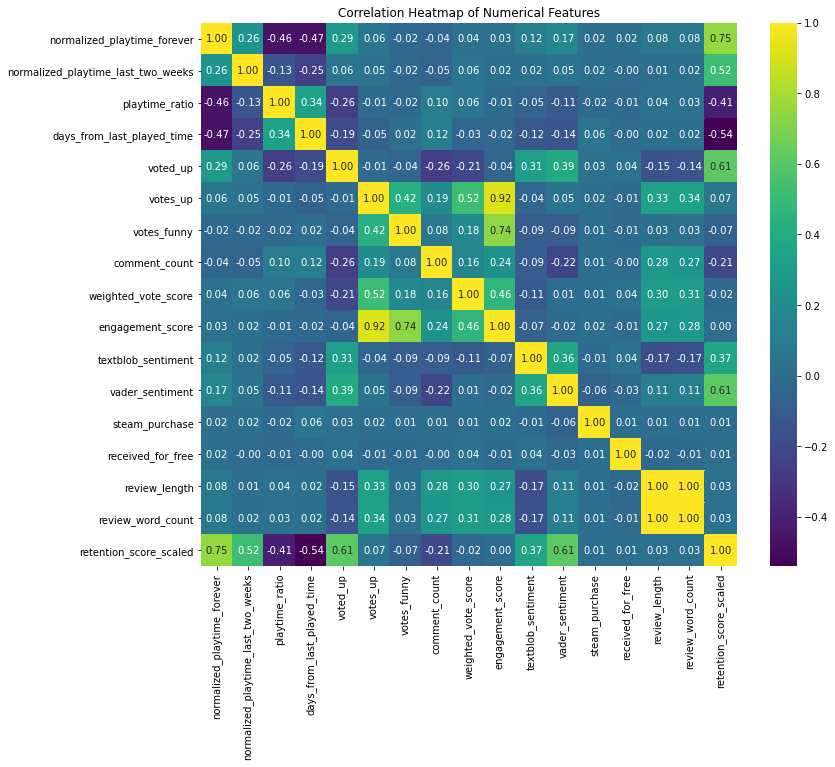

In [13]:
# Selecting only numerical features for correlation
numerical_data = reviews_df[numerical_features]

# Appending 'retention_score_scaled' to DataFrame
numerical_data_with_target = numerical_data.copy()
numerical_data_with_target['retention_score_scaled'] = reviews_df['retention_score_scaled']

# Computing the correlation matrix including the target variable
corr_matrix = numerical_data_with_target.corr()

# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

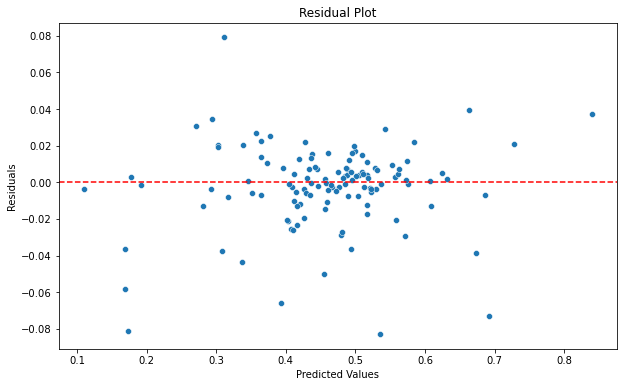

In [7]:
# Calculating residuals
residuals = y_test - y_pred

# Creating the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residual Plot of Baseline Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Adding a horizontal line at zero for reference (perfect prediction)
plt.show()

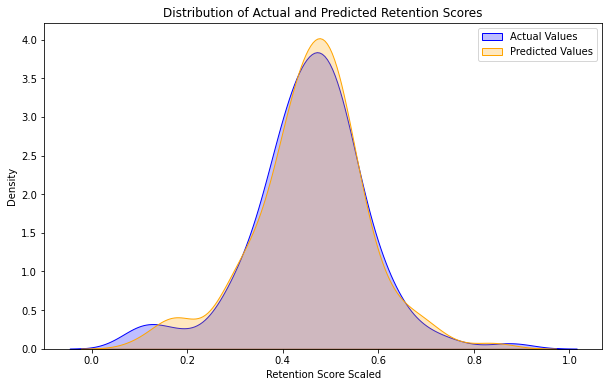

In [8]:
# Plotting the distribution of actual and predicted Retention Scores
plt.figure(figsize=(10, 6))

# Plotting the actual values
sns.kdeplot(y_test, label='Actual Values', color='blue', shade=True)

# Plotting the predicted values
sns.kdeplot(y_pred, label='Predicted Values', color='orange', shade=True)

# Adding title and labels
plt.title('Distribution of Actual and Predicted Retention Scores')
plt.xlabel('Retention Score Scaled')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [9]:
from sklearn.model_selection import KFold
import numpy as np

# Number of folds
n_splits = 5

# Shuffling datasets each time for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initializing lists to store the metrics of the model for each fold
mse_scores = []
r2_scores = []

# Initialize lists to store prediction and actual scores for each fold
all_y_pred = []
all_y_test = []

# Initializing k-fold cross-validation loop (necessary to keep it consistent with original model)
for train_index, test_index in kf.split(X):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Creating a new instance of the model pipeline for each fold
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

    # Training the model
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Appending the scores
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Storing predictions and actual values
    all_y_pred.extend(y_pred)
    all_y_test.extend(y_test)

# Calculating and printing the average scores across all folds
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {average_mse}")
print(f"Average R-squared: {average_r2}")


Average Mean Squared Error: 0.0006432014211117612
Average R-squared: 0.9648447205346533


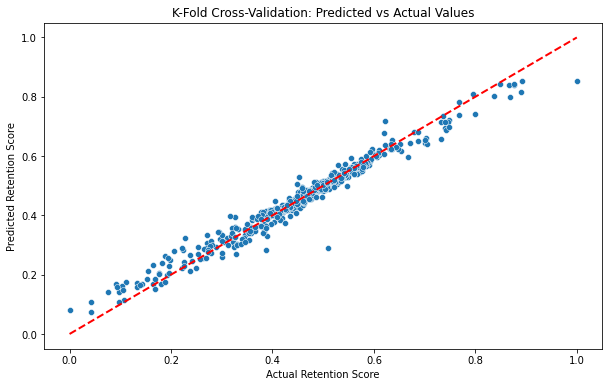

In [10]:
# Plotting Predicted vs Actual for K-Fold Cross-Validation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_test, y=all_y_pred)
plt.title('K-Fold Cross-Validation for Random Forest Model: Predicted vs Actual Values')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for reference
plt.show()